# Modelo Predicción de Ocupación

## Contenido
* Importacion de biblioticas
* Carga de los datos
* Integración de Fuentes
 * Unificación 
* Calculo variable Beta y Delta
* Correlaciones
* Correlaciones Cruzadas
* Exploración Datos OOKLA

## Importacion de biblioticas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from datetime import datetime
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix # es una manera para resumir los datos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve #roc_curve
from sklearn.metrics import roc_auc_score #auc
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Carga de los datos

In [3]:
df_Nodosokla= pd.read_csv('DatosOrigen/NODOS_INFO_OOKLA.csv',sep=';', header = 0)
data_ocupacionNodo = pd.read_csv('DatosOrigen/OCUPACION_NODO.csv', sep=';')
data_NodoINFI = pd.read_csv('DatosOrigen/NODO_INFI.csv', sep=';')
data_SEG = pd.read_csv('DatosOrigen/compiladoFinal.csv', sep=';') 

### Base OOKLA

In [4]:
df_Nodosokla['DIA']=1 # le agrego la columna dia
df_Nodosokla['MES'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['MES']]
df_Nodosokla['DIA'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['DIA']]
df_Nodosokla['FECHA'] = df_Nodosokla['ANIO'].astype('str') + '-' + df_Nodosokla['MES'] + '-' + df_Nodosokla['DIA']
# eliminamos columnas cobrantes
df_Nodosokla=df_Nodosokla.drop(['DIA','MES','ANIO'], axis=1)
# ordenamos
df_Nodosokla = df_Nodosokla[['NODO','FECHA', 'OPERADOR','CANTIDAD','DOWNLOAD_KBPS','UPLOAD_KBPS','LATENCY','FLAG_LAT']] 
# # renombramos columnas
df_Nodosokla.rename(columns={'NODO':'COD_NODO'}, inplace=True)
df_Nodosokla_Claro=df_Nodosokla[df_Nodosokla["OPERADOR"]=="CLARO"]
del(df_Nodosokla_Claro['OPERADOR'])

In [5]:
df_Nodosokla_Otros=df_Nodosokla[df_Nodosokla["OPERADOR"]!="CLARO"]

In [6]:
df_Nodosokla_Otros.head(3)

,COD_NODO,FECHA,OPERADOR,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT
0,CT511M,2021-04-01,MOVISTAR,1,7.578125,0.857422,35.000000,0
1,49J,2020-10-01,TIGO,819,22.327406,4.453991,30.362637,0
2,UD74D,2021-06-01,MOVISTAR,2,6.027344,0.693359,30.000000,0


In [7]:
data_por_area3=df_Nodosokla_Otros.groupby(by = ['COD_NODO','FECHA']).agg({'DOWNLOAD_KBPS':'max'})
data_por_area3=data_por_area3.reset_index()
data_por_area3.rename(columns={'DOWNLOAD_KBPS':'DW_MAX'}, inplace=True)

In [8]:
data_por_area3.head()

,COD_NODO,FECHA,DW_MAX
0,01J,2020-08-01,50.519531
1,01J,2020-09-01,10.347982
2,01J,2020-10-01,12.777344
3,01J,2021-02-01,11.169922
4,01J,2021-03-01,78.462891


In [9]:
df_Nodosokla_Claro.head()

,COD_NODO,FECHA,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT
4,1TM,2020-09-01,15,32.773177,6.304427,18.333333,0
5,KE1,2021-01-01,45,37.248828,5.959115,22.311111,0
7,BCL,2021-04-01,15,80.636654,8.588867,20.400000,0
13,UGA,2021-01-01,2,103.791992,10.645996,18.000000,0
20,SDG,2020-08-01,45,42.983854,4.510308,38.733333,0


### Base data_NodoINF

In [10]:
data_NodoINFI['DIA']=1 # le agrego la columna dia
data_NodoINFI['MES'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['MES']]
data_NodoINFI['DIA'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['DIA']]
data_NodoINFI['FECHA'] = (2000+data_NodoINFI['ANIO']).astype('str') + '-' + data_NodoINFI['MES'] + '-' + data_NodoINFI['DIA']
# eliminamos columnas sobrantes
data_NodoINFI=data_NodoINFI.drop(['DIA','MES','ANIO'], axis=1)
# # renombramos columnas
data_NodoINFI.rename(columns={'NODO':'COD_NODO'}, inplace=True)
### completar Nullos con 0
data_NodoINFI=data_NodoINFI.fillna(0)

### Base data_NodoINF data_SEG

In [11]:
data_SEG.drop(['NUEVA ESTRUCTURA'], axis=1,inplace=True)
data_SEG['SEGMENTADO']=1

## Integración Fuentes

In [12]:
data_ocupacion=pd.merge(data_ocupacionNodo, data_NodoINFI, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, df_Nodosokla_Claro, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, data_por_area3, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, data_SEG, on = ('COD_NODO','FECHA'), how='left')

## Factor beta y delta

In [13]:
data_ocupacion['Delta']=np.where(data_ocupacion['DOWNLOAD_KBPS'] !=0, data_ocupacion['DW_MAX'].div(data_ocupacion['DOWNLOAD_KBPS']),0)
data_ocupacion['Beta']=np.where(data_ocupacion['PROM_VEL'] !=0, data_ocupacion['DW_MAX'].div(data_ocupacion['PROM_VEL']),0)

In [14]:
data_ocupacion.head()

,COD_NODO,FECHA,OCUPACION_DW,OCUPACION_UP,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,...,CANT_CALL,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT,DW_MAX,SEGMENTADO,Delta,Beta
0,0SM,2021-06-01,0.645369,0.358797,189.0,56.0,45.0,26.0,4.0,40.0,...,17.0,8.0,63.500488,7.214722,10.75,2.0,98.814941,NaN,1.556129,1.764553
1,RD6,2020-08-01,0.355756,0.439774,45.0,47.0,40.0,1.0,6.0,15.0,...,1.0,NaN,NaN,NaN,NaN,NaN,105.063477,NaN,NaN,2.235393
2,VRS12D,2020-11-01,0.555039,0.235540,101.0,41.0,45.0,5.0,17.0,23.0,...,6.0,4.0,58.528564,7.889648,11.50,2.0,34.932861,NaN,0.596851,0.852021
3,3NM,2020-08-01,0.276692,0.268652,211.0,18.0,10.0,77.0,62.0,44.0,...,14.0,20.0,41.382178,7.386865,26.50,0.0,5.142090,NaN,0.124259,0.285672
4,PKE,2020-06-01,0.355112,0.124435,90.0,17.0,10.0,32.0,31.0,16.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


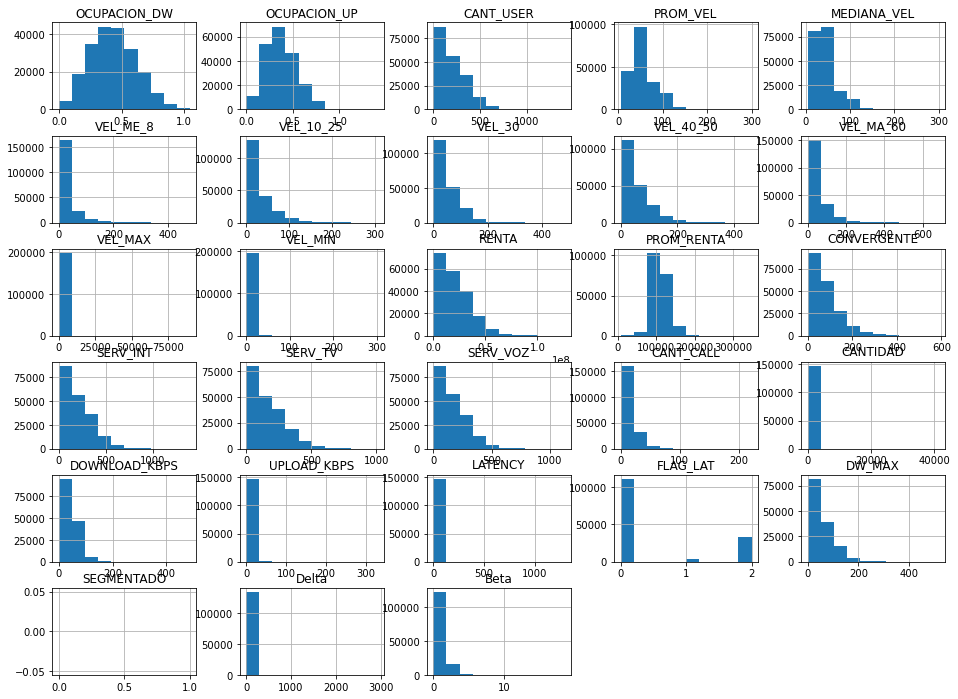

In [15]:
data_ocupacion.hist(figsize=(16,12));

In [16]:
# para ver el grado de correlación entre las variables disponibles.
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = data_ocupacion.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
407,SERV_INT,CANT_USER,1.000000,1.000000
69,CANT_USER,SERV_INT,1.000000,1.000000
447,SERV_TV,SERV_INT,0.986344,0.986344
421,SERV_INT,SERV_TV,0.986344,0.986344
70,CANT_USER,SERV_TV,0.986344,0.986344
434,SERV_TV,CANT_USER,0.986344,0.986344
449,SERV_TV,SERV_VOZ,0.982526,0.982526
475,SERV_VOZ,SERV_TV,0.982526,0.982526
471,SERV_VOZ,RENTA,0.976953,0.976953
341,RENTA,SERV_VOZ,0.976953,0.976953


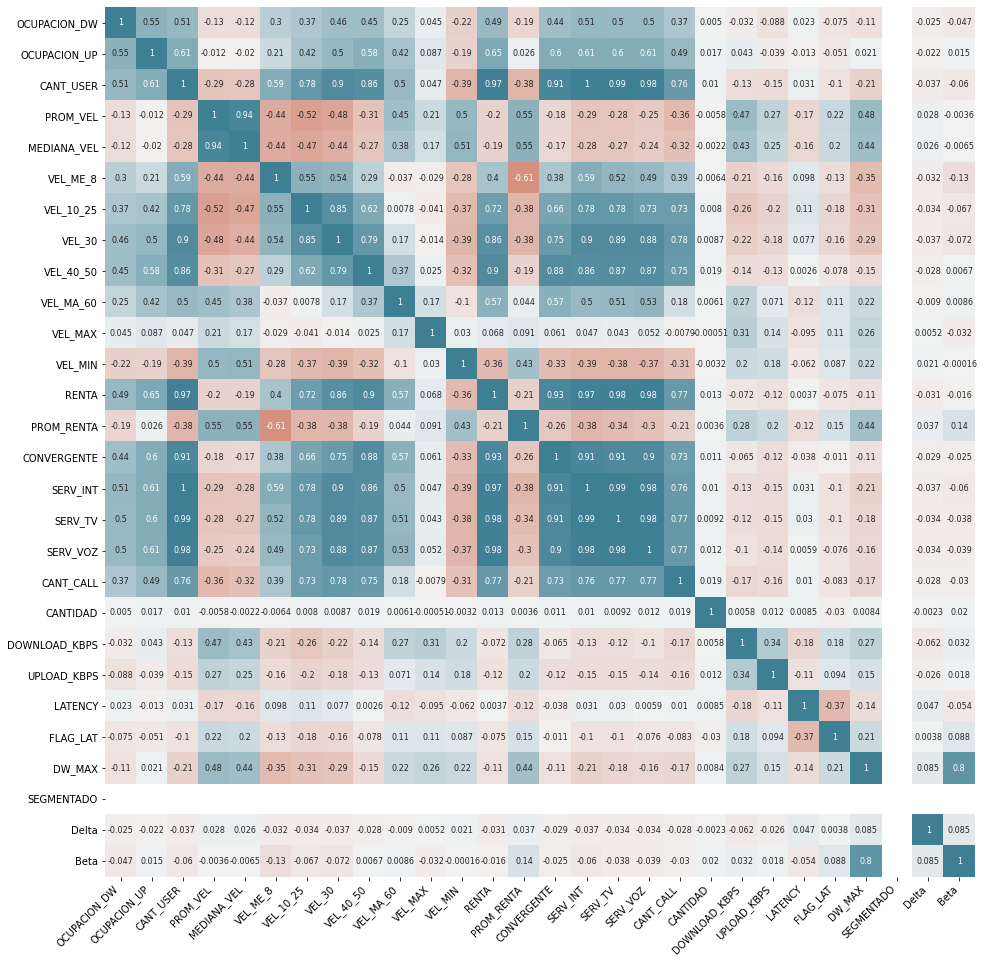

In [17]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 16))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

<AxesSubplot:xlabel='Beta', ylabel='PROM_VEL'>

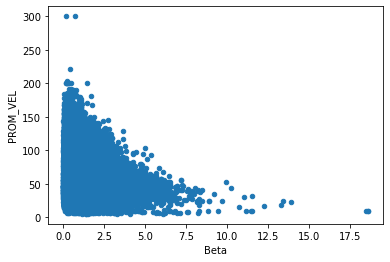

In [18]:
data_ocupacion.plot.scatter(x='Beta', y='PROM_VEL')

<AxesSubplot:xlabel='Delta', ylabel='DOWNLOAD_KBPS'>

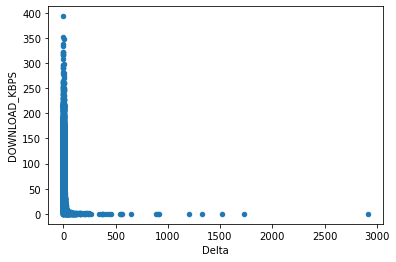

In [19]:
data_ocupacion.plot.scatter(x='Delta', y='DOWNLOAD_KBPS')

<AxesSubplot:xlabel='Delta', ylabel='Beta'>

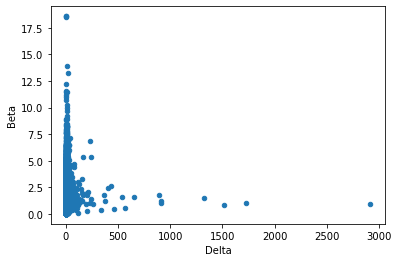

In [20]:
data_ocupacion.plot.scatter(x='Delta', y='Beta')

In [21]:
data_ocupacion[['PROM_VEL','DOWNLOAD_KBPS','DW_MAX','Beta','Delta']].describe().T

,count,mean,std,min,25%,50%,75%,max
PROM_VEL,198396.0,54.912004,26.801769,5.0,36.000000,47.000000,68.000000,300.000000
DOWNLOAD_KBPS,147619.0,46.635961,27.085187,0.0,28.730298,40.383138,57.910050,488.109075
DW_MAX,141965.0,55.807350,46.526858,0.0,21.383789,41.876904,81.075008,516.664551
Beta,138956.0,1.016270,0.763669,0.0,0.490047,0.848175,1.381699,18.584180
Delta,134948.0,1.648786,13.196643,0.0,0.529750,1.011984,1.809219,2914.456659


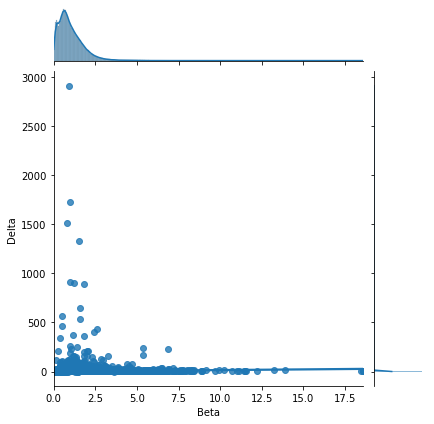

In [22]:
sns.jointplot(x=data_ocupacion['Beta'],y=data_ocupacion['Delta'],data=data_ocupacion,kind='reg')

#### Correlaciones Cruzadas

In [25]:
def get_correlation_table(metric_df):
    metric_cnt = metric_df.shape[1]
    correlation_table = np.zeros((metric_cnt, metric_cnt))
    for i in range(metric_cnt):
        metric_df1=metric_df[metric_df[metric_df.columns[i]].notna()]        
        #metric_1 = metric_df.iloc[:, i]
        for j in range(metric_cnt):
            if i == j:
                continue
            else:
                metric_df2=metric_df1[metric_df1[metric_df1.columns[j]].notna()]
                if len(metric_df2)>4:
                    metric_1 = metric_df2.iloc[:, i]
                    metric_2 = metric_df2.iloc[:, j]
                    cc_ary = ccf(metric_1, metric_2, unbiased=False)
                    correlation_table[i, j] = cc_ary[0]
    return correlation_table

In [26]:
data_ocupacion=data_ocupacion.sort_values(["COD_NODO", "FECHA"], ascending = (True, True))

In [27]:
data_ocupacion=data_ocupacion.reset_index(drop=True)

In [28]:
listaNodos=data_ocupacion['COD_NODO'].unique()
metric_cnt = 25

In [29]:
correlation_table = np.zeros((metric_cnt, metric_cnt))
flag = np.zeros((metric_cnt, metric_cnt))
correlation_table=pd.DataFrame(correlation_table)
for i in range(metric_cnt):
    correlation_table[i]=correlation_table[i].astype('object')

In [ ]:
for nodo in listaNodos:
    data_ocupacionUnNodo=data_ocupacion[data_ocupacion['COD_NODO']==nodo]
    data_ocupacionUnNodo.drop(['COD_NODO','FECHA'], axis=1,inplace=True)
    for i in range(metric_cnt):        
        data_ocupacionUnNodo1=data_ocupacionUnNodo[data_ocupacionUnNodo[data_ocupacionUnNodo.columns[i]].notna()]
        for j in range(metric_cnt):
            if i == j:
                continue
            else:
                data_ocupacionUnNodo2=data_ocupacionUnNodo1[data_ocupacionUnNodo1[data_ocupacionUnNodo1.columns[j]].notna()]
                if len(data_ocupacionUnNodo2)>4:
                    metric_1 = data_ocupacionUnNodo2.iloc[:, i]
                    metric_2 = data_ocupacionUnNodo2.iloc[:, j]
                    cc_ary = ccf(metric_1, metric_2, unbiased=False)
                    if flag[i, j]==0 :
                        correlation_table.at[i,j]=np.array([cc_ary[0]])
                        flag[i, j]=1                        
                    else :
                        correlation_table.at[i,j]=np.append(correlation_table.at[i,j],cc_ary[0])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
the 'unbiased'' keyword is deprecated, use 'adjusted' instead


In [ ]:
with np.printoptions(threshold=np.inf):
    print(correlation_table[0][2])

In [ ]:
np.nanmean(correlation_table[0][2])
cross_corr_mean=np.zeros((metric_cnt, metric_cnt))
cross_corr_median=np.zeros((metric_cnt, metric_cnt))
cross_corr_per75=np.zeros((metric_cnt, metric_cnt))

In [ ]:
for i in range(metric_cnt):
    for j in range(metric_cnt):
        if flag[i,j]==0:
            cross_corr_mean[i,j]=0
            cross_corr_median[i,j]=0
            cross_corr_per75[i,j]=0
        else:
            cross_corr_mean[i,j]=np.nanmean(correlation_table[i][j]) 
            cross_corr_median[i,j]=np.nanmedian(correlation_table[i][j]) 
            cross_corr_per75[i,j]=np.nanpercentile(correlation_table[i][j],75) 

### Mean

In [ ]:
cross_corr_mean=pd.DataFrame(cross_corr_mean, index=data_ocupacionUnNodo.columns, columns=data_ocupacionUnNodo.columns)
corrMapaCalor(cross_corr_mean,26,16)

### Median

In [47]:
cross_corr_median=pd.DataFrame(cross_corr_median, index=data_ocupacionUnNodo.columns, columns=data_ocupacionUnNodo.columns)
corrMapaCalor(cross_corr_median,26,16)

NameError: name 'cross_corr_median' is not defined

### percentil 75

In [ ]:
cross_corr_per75=pd.DataFrame(cross_corr_per75, index=data_ocupacionUnNodo.columns, columns=data_ocupacionUnNodo.columns)
corrMapaCalor(cross_corr_per75,26,16)

### Exploración OOKLA

In [28]:
df_Nodosok= pd.read_csv('DatosOrigen/NODOS_INFO_OOKLA.csv',sep=';', header = 0)
df_Nodosok['MES'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosok['MES']]
df_Nodosok['FECHA'] = df_Nodosok['ANIO'].astype('str') + '-' + df_Nodosok['MES']
df_Nodosok[['FECHA', 'NODO', 'OPERADOR', 'CANTIDAD','DOWNLOAD_KBPS','UPLOAD_KBPS','LATENCY','FLAG_LAT']] 

,FECHA,NODO,OPERADOR,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT
0,2021-04,CT511M,MOVISTAR,1,7.578125,0.857422,35.000000,0
1,2020-10,49J,TIGO,819,22.327406,4.453991,30.362637,0
2,2021-06,UD74D,MOVISTAR,2,6.027344,0.693359,30.000000,0
3,2021-01,BHS,MOVISTAR,3,3.940755,0.980143,37.666667,0
4,2020-09,1TM,CLARO,15,32.773177,6.304427,18.333333,0
...,...,...,...,...,...,...,...,...
394886,2021-06,SEV,MOVISTAR,38,140.379163,124.683825,8.473684,1
394887,2021-04,ZH24D,TIGO,1,33.525391,10.325195,44.000000,0
394888,2020-08,3VE,CLARO,2,33.431641,6.925781,25.500000,0
394889,2021-07,CZA,CLARO,7,61.031390,8.493722,15.285714,0


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


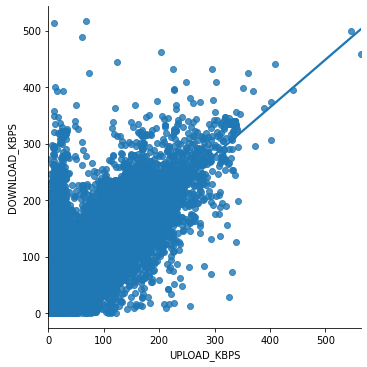

In [30]:
# essto me muestra que hay unna relacion lineal entre 'UPLOAD_KBPS', 'DOWNLOAD_KBPS'
from seaborn import lmplot
lmplot('UPLOAD_KBPS', 'DOWNLOAD_KBPS', data=df_Nodosok)

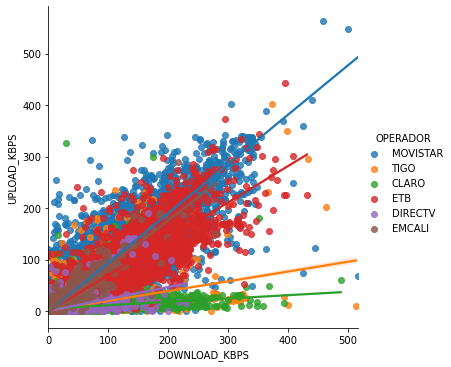

In [31]:
# muestra la relacion lineal con otros operadores
lmplot(x="DOWNLOAD_KBPS", y="UPLOAD_KBPS", hue="OPERADOR", data=df_Nodosok)

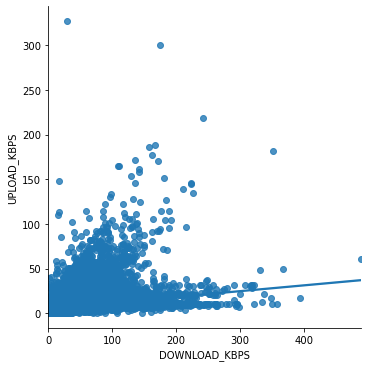

In [33]:
#  tendencia de datos para claro
lmplot(x="DOWNLOAD_KBPS", y="UPLOAD_KBPS", data=df_Nodosokla[df_Nodosok['OPERADOR']=='CLARO'])

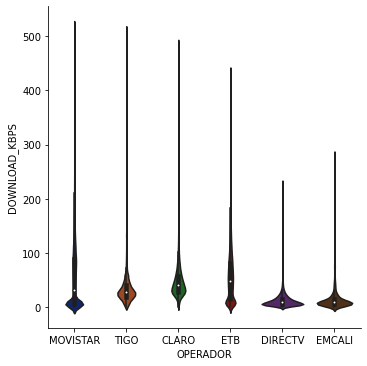

In [34]:
sns.catplot(y="DOWNLOAD_KBPS", x="OPERADOR", kind="violin", palette="dark", data=df_Nodosok)

In [35]:
df_Nodosok.describe()

,ANIO,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT
count,394891.000000,394891.000000,394891.000000,394891.000000,394891.000000,394891.000000
mean,2020.582941,32.052670,43.881678,20.351471,26.770443,0.527123
std,0.493073,402.038394,37.467096,33.387853,46.413833,0.790358
min,2020.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2020.000000,2.000000,17.893156,4.791016,12.657895,0.000000
50%,2021.000000,7.000000,34.329102,7.235677,20.000000,0.000000
75%,2021.000000,16.000000,59.247984,13.273401,30.367007,1.000000
max,2021.000000,41421.000000,516.664551,563.410156,7619.000000,2.000000


<AxesSubplot:xlabel='OPERADOR', ylabel='count'>

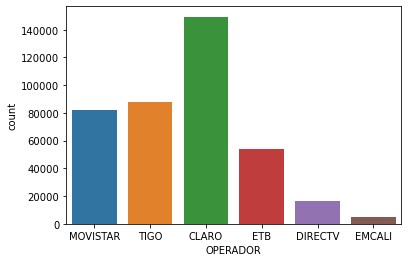

In [36]:
# Operadorcon mas registros en ookla
sns.countplot(x='OPERADOR', data=df_Nodosok)

In [37]:
df_Nodosok.groupby(by='OPERADOR')['DOWNLOAD_KBPS','UPLOAD_KBPS','LATENCY','FLAG_LAT'].max() # nos agrupa por operador y por cada tipo de funcion nos aplica la funcion maxima aplicado a cada operador

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY,FLAG_LAT
OPERADOR,,,,
CLARO,488.109075,327.014648,1293.6,2
DIRECTV,229.664062,191.348145,7619.0,2
EMCALI,280.154297,290.474609,3856.0,2
ETB,431.687500,442.497070,1763.0,2
MOVISTAR,516.664551,563.410156,5522.0,2
TIGO,513.701172,401.611328,3205.0,2


In [38]:
# analisis estadistico con la variable DOWNLOAD_KBPS
x = df_Nodosok['DOWNLOAD_KBPS'].values # returns # CANTIDAD	DOWNLOAD_KBPS	UPLOAD_KBPS	LATENCY	FLAG_LAT
x_str='Real returns'  # label e,g ric
x_size= len(x)  #  retorna el tamaño df_Nodosokla['CANTIDAD'].shape
print(x_size)
# round_digits = 4
from scipy.stats import skew, kurtosis, chi2

x_mean = np.mean(x) # para calcular la  media
x_std =np.std(x) # para la desviacion estandar o volatilidad si se habla de mercados
x_skew = skew(x) # para calcular la skweness o simetria
x_kurt = kurtosis(x) # curtosis en exceso, para calcular la kurtosis y ver que tantas colas largas tiene
x_sharpe = x_mean/x_std # esto es el rendimiento en unidades de riesgo
x_var_95 = np.percentile(x,95) # valor en riesgo esto nos dice que solamente el 5% de los valores son mayores, el valor arrojado en este caso mayores a 1.64
x_cvar_95 = np.mean(x[x <= x_var_95]) # valor en riesgo condicional, esto nos dice, que cuando pierdo que tanto pierdo, esto es el promedio de todos los valores que estan a la isquierda osea que se encuentran en el -5% en este caso
x_sharpe = x_mean / x_std * np.sqrt(252) # indica el rendimiento esperado por unidad de riesgo 252 eselnumero de dias anuales trabajados
x_corrcoef = np.corrcoef(x) # coeficiente de correlacion
x_var = np.var(x) # covarianza
# Test de jarque-bera
jb = x_size/6*(x_skew**2 + 1/4*x_kurt**2) # jarque bera
# p-value
p_value = 1 - chi2.cdf(jb, df=2) # se deben fijar df en 2 para la t-student, df= grados de liberdad 
is_normal = (p_value > 0.05) # con esto necesitamos que equivalently jb < 6

394891


In [39]:
print('media               =', x_mean)
print('desviacion estandar =', x_std) # indica qué tan dispersos están los datos con respecto a la media para la desviacion estandar o volatilidad si se habla de mercado
print('skweness            =', x_skew) # skweness es una variable aleatoria
print('kurtosis            =', x_kurt) # curtosis en exceso, determina el grado de concentración que presentan los valores de una variable alrededor de la zona central de la distribución de frecuencias
print('x_sharpe            =', x_sharpe)
print('valor en riesgo     =', x_var_95) # Valor en riesgo esto nos dice que solamente el 5% de los valores son mayores, el valor arrojado en este caso mayores
print('riesgo condicional  =', x_cvar_95)
print('x_sharpe            =', x_sharpe)
print('Coefic correlacion  =', x_corrcoef)
print('varianza            =', x_var)
print('jarque bera         =', jb) # si se tiene un jarque bera > 6 la distribucion no es normal
print('p_value             =', p_value) # p < 0,05 significa que la hipótesis nula es falsa y una p > 0,05 que la hipótesis nula es verdadera: # esto me da la probabilidad de que suponiendo que tenga una distribicion chi2, cual seria la probabilidad # de tener puntos que caigan a la izquierda de dicho valor
print('is_normal           =', is_normal) 

media               = 43.88167752520961
desviacion estandar = 37.46704883668058
skweness            = 1.8298055051315756
kurtosis            = 5.632433461819595
x_sharpe            = 18.592337979452594
valor en riesgo     = 116.9334716796875
riesgo condicional  = 38.151097686349495
x_sharpe            = 18.592337979452594
Coefic correlacion  = 1.0
varianza            = 1403.7797485302076
jarque bera         = 742346.6967743565
p_value             = 0.0
is_normal           = False


### Exploracion de datos NODO_INFI

In [136]:
data_NodoINFI

,COD_NODO,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,VEL_40_50,VEL_MA_60,VEL_MAX,VEL_MIN,RENTA,PROM_RENTA,CONVERGENTE,SERV_INT,SERV_TV,SERV_VOZ,CANT_CALL,FECHA,Promedio de velocidades
0,10,54,56,50,0.0,4.0,8.0,25.0,17.0,150,10.0,6660222,123337,18,54,40,47,5.0,2021-01-01,30.571429
1,10,53,58,50,0.0,2.0,8.0,26.0,17.0,150,10.0,6566817,123902,18,53,39,46,8.0,2021-02-01,30.428571
2,10,56,60,50,0.0,2.0,8.0,26.0,20.0,150,10.0,7017707,125316,18,56,41,47,5.0,2021-03-01,30.857143
3,10,55,77,60,0.0,2.0,7.0,18.0,28.0,160,10.0,6797236,123586,19,55,40,46,1.0,2021-04-01,32.142857
4,10,56,82,68,0.0,1.0,7.0,18.0,30.0,160,15.0,6813012,121661,20,56,42,47,3.0,2021-05-01,33.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266759,VRZ14D,96,30,30,17.0,20.0,34.0,19.0,6.0,150,5.0,9340048,97292,33,96,83,74,2.0,2020-08-01,35.857143
266760,VRZ14D,100,32,30,20.0,15.0,30.0,26.0,9.0,150,5.0,9444951,94450,34,100,84,75,10.0,2020-09-01,36.428571
266761,VRZ14D,100,32,30,21.0,15.0,28.0,27.0,9.0,150,5.0,9563772,95638,37,100,84,75,10.0,2020-10-01,36.428571
266762,VRZ14D,107,32,30,24.0,14.0,30.0,29.0,10.0,150,5.0,10053075,93954,36,107,89,82,7.0,2020-11-01,37.428571


In [137]:
data_NodoINFI['Promedio de velocidades']=(data_NodoINFI['VEL_ME_8']+data_NodoINFI['VEL_10_25']+
data_NodoINFI['VEL_30']+data_NodoINFI['VEL_40_50']+data_NodoINFI['VEL_MA_60']+data_NodoINFI['VEL_MAX']+
data_NodoINFI['VEL_MIN'])/7

In [139]:
data_NodoINFI.head()

,COD_NODO,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,VEL_40_50,VEL_MA_60,VEL_MAX,VEL_MIN,RENTA,PROM_RENTA,CONVERGENTE,SERV_INT,SERV_TV,SERV_VOZ,CANT_CALL,FECHA,Promedio de velocidades
0,10,54,56,50,0.0,4.0,8.0,25.0,17.0,150,10.0,6660222,123337,18,54,40,47,5.0,2021-01-01,30.571429
1,10,53,58,50,0.0,2.0,8.0,26.0,17.0,150,10.0,6566817,123902,18,53,39,46,8.0,2021-02-01,30.428571
2,10,56,60,50,0.0,2.0,8.0,26.0,20.0,150,10.0,7017707,125316,18,56,41,47,5.0,2021-03-01,30.857143
3,10,55,77,60,0.0,2.0,7.0,18.0,28.0,160,10.0,6797236,123586,19,55,40,46,1.0,2021-04-01,32.142857
4,10,56,82,68,0.0,1.0,7.0,18.0,30.0,160,15.0,6813012,121661,20,56,42,47,3.0,2021-05-01,33.000000


(0.0, 500.0)

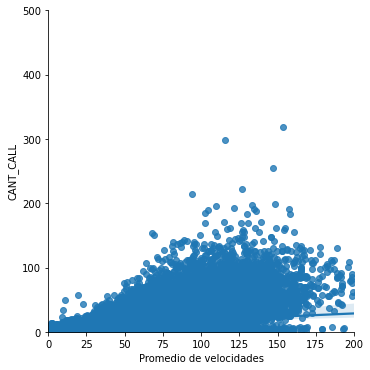

In [115]:
lmplot(x="Promedio de velocidades", y="CANT_CALL", palette="Set1", data=data_NodoINFI)
plt.xlim(0,200)
plt.ylim(0,500)

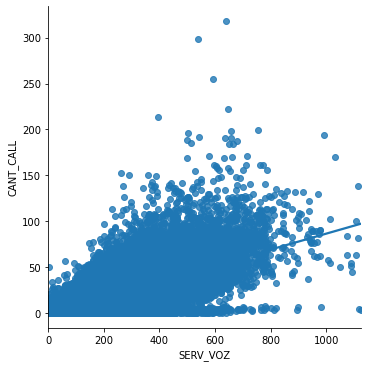

In [47]:
lmplot(x="SERV_VOZ", y="CANT_CALL", data=data_NodoINFI)

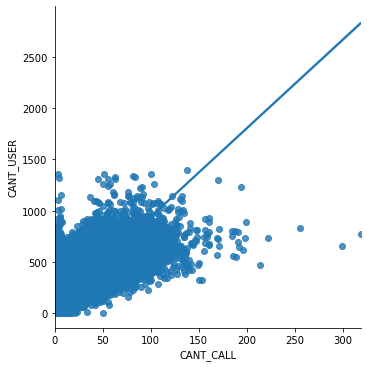

In [54]:
lmplot(y="CANT_USER", x="CANT_CALL", data=data_NodoINFI)

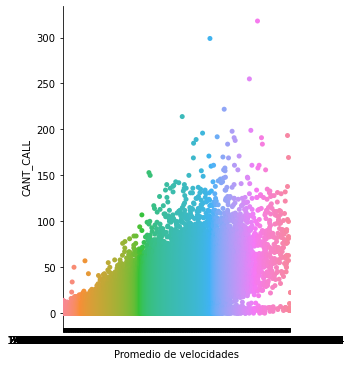

In [120]:
sns.catplot(y="CANT_CALL", x="Promedio de velocidades", data=data_NodoINFI)